# Homework 3: EDA. Interactive visualizations

У цьому домашньому завданні ми будемо працювати з набором даних, що містить ціни на будинки в місті Еймс штату Айова.    
Дані можна знайти у `data/ames_house_prices/`. Опис даних – у `data/ames_house_prices/data_description.txt`. Прочитайте опис змінних перед виконанням завдання, ми будемо користуватися ним, щоб зрозуміти дані.  
Дані взяті зі [змагання](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) на Kaggle.

Цей набір даних має багато ознак – все як у реальному житті. І ми будемо аналізувати закономірності у цьому наборі даних.
У цьому ДЗ ми відпрацюємо деякі етапи EDA, тому що з функціоналом для його виконання ви вже частково знайомі. Етапи повного EDA були розглянуті у лекції.

0. У процесі роботи розміщуйте угорі ноутбука, імпорт усіх необхідних вам бібліотек. Це добрий стиль ведення ноутбука.

In [64]:
import pandas as pd
import seaborn as sns

print(f"pandas: {pd.__version__}")
print(f"seaborn: {sns.__version__}")

pandas: 1.5.3
seaborn: 0.12.2


1. Завантажте `train.csv` у змінну `df_train`.

In [13]:
url = 'https://raw.githubusercontent.com/dmytrovelychko/rd_ds_python/main/datasets/hw_3/train.csv'
df_train = pd.read_csv(url)

In [20]:
df_train[-5:]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


2. Виведіть інформацію про колонки у наборі даних, їх типах, кількості **не** null значень у кожній колонці та формі набору даних.

In [62]:
# pd.set_option('display.max_rows', 60)
def highlight_nullable(row):
  if row.loc["non_null_count"] < df_train.shape[0]:
    color = '#FFB3BA' # red
  else:
    color = '#BAFFC9' # green
  return [f"background-color: {color}; color: black" for r in row]

df_train_count = df_train.count()
df_base_info = pd.concat(
    [df_train.dtypes, df_train_count, round(df_train_count/df_train.shape[0]*100)],
    keys=["type_name", "non_null_count", "non_null_percentage"],
    axis=1)

print(df_train.shape)
df_base_info.style.apply(highlight_nullable, axis=1)

(1460, 81)


,type_name,non_null_count,non_null_percentage
Id,int64,1460,100.000000
MSSubClass,int64,1460,100.000000
MSZoning,object,1460,100.000000
LotFrontage,float64,1201,82.000000
LotArea,int64,1460,100.000000
Street,object,1460,100.000000
Alley,object,91,6.000000
LotShape,object,1460,100.000000
LandContour,object,1460,100.000000
Utilities,object,1460,100.000000


3. Задача, яку ми розглядаємо – це задачі регресії. Наша цільова змінна – `SalePrice`. І у задачі регресії потрібно буде її передбачити. Нам важливо зрозуміти, як вона розподілена та як взаємодіє з іншими змінними.
Найкраще моделюються змінні, близькі до нормального розподілу.

3.1. Побудуйте функцію щільності (розподіл даних) `SalePrice` за допомогою `seaborn`.

<Axes: xlabel='SalePrice', ylabel='Density'>

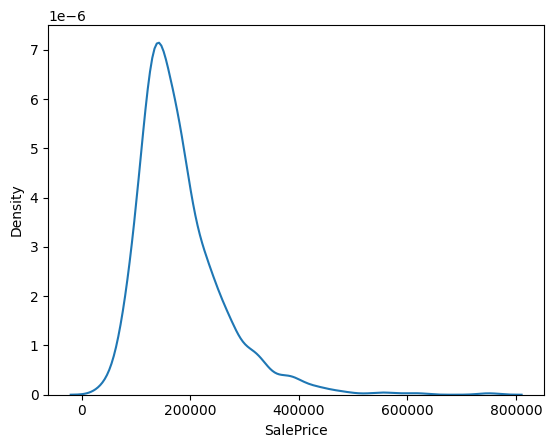

In [71]:
sns.kdeplot(df_train["SalePrice"])

3.2. Виведіть асиметрію та ексцес (на англ. - skewness and kurtosis) для `SalePrice` (не візуально, відповідь у числовому форматі).

In [72]:
print("skewneww:", df_train["SalePrice"].skew()) # 1.88 > high asymmetry to the right side
print("kurtosis:", df_train["SalePrice"].kurt()) # 6.53 > 3 => leptokurtic => tails aren't heavy

skewneww 1.8828757597682129
kurtosis 6.536281860064529


Бачимо, що змінну зміщено. Те, наскільки вона схожа на нормальний розподіл, ми навчимося обчислювати трохи пізніше на курсі.

4. Побудуйте матрицю кореляції, яка міститиме цільову змінну `SalePrice` і усі **числові**. Відобразіть її у вигляді теплової карти.

- Матриця може бути трикутною (без верхньої правої частини, яка симетрична нижній лівій), повною або лише один рядок, що містить кореляції зі змінною `SalePrice`. Але обов'язково має бути зафарбована залежно від значення клітини матриці.  


- Числові змінні необхідно вибрати, використовуючи функцію `pandas`, передавати списком буде вважатися неправильним виконанням.  
Якщо на вашу думку деякі змінні необхідно перетворити на числові перед побудовою потрібної в цьому завданні візуалізації – перетворіть, але якщо не перетворите це не буде помилкою.
Суть завдання – виділити функцією лише числові змінні та відобразити матрицю кореляції візуально. Не обов'язково підписувати значення у клітинах матриці кореляції. Нам важливо зрозуміти, з якими ознаками таргет корелює добре, а з якими – ні.


- Фінальний графік має бути зручним для сприйняття, читаним, таким, який ви додали б у презентацію для менеджменту.

In [ ]:
# ваш код тут

Які висновки можна зробити із побудованої матриці кореляцій? Які числові ознаки потенційно сильно впливають на цільову змінну, які – ні?

*ваші думки тут*

4.1. Знайдіть топ 10 змінних (не включаючи саму `SalePrice`), з якими `SalePrice` має найбільшу позитивну кореляцію. Виведіть ці змінні та кореляцію з ними.

In [ ]:
# ваш код тут

4.2. Побудуйте теплову карту кореляцій тільки серед змінних `SalePrice` та топ 10, що корелюють із нею. На тепловій карті виведіть числом із двома цифрами після коми міру кореляції між кожною парою змінних.

In [ ]:
# ваш код тут

4.3. Проаналізуйте отриманий результат. На вашу думку, чи логічно, що саме ці ознаки найбільше корелюють з цільовою змінною? Обґрунтуйте свою відповідь.

In [ ]:
# ваша відповідь тут

5. Побудуйте трикутний pairplot для `SalePrice` і топ 10 ознак у наборі даних, що корелюють з нею.
Додайте лінії тренду до даних (параметр `kind`). По діагоналі виведіть kernel density estimation (kde) змінних.

In [ ]:
# ваш код тут

Ми можемо бачити точки, які начебто не потрапили до загального кластеру. Їх називають аутлаєрами (с англ. outliers) або викидами. Такими є, наприклад, точки з невисокою `SalePrice` і при цьому високе значення `GrLivArea`, або точка зі значенням `TotalBsmtSF` близько 6000 і при цьому низьким `SalePrice`. Давайте розглянемо, що це за точки.

5.1. Виведіть точки з `GrLivArea` строго більше 4000.

In [ ]:
# ваш код тут

5.2. Не всі колонки помістилися при виведенні? Встановіть параметр `display.max_columns` рівний 100. І виведіть запитувані дані в п.5.1, ще раз, щоб було зручно аналізувати дані.

In [ ]:
# ваш код тут

5.3. Для даних отриманих у п.5.1 дайте відповідь на питання: чим відрізняються точки з обраних, у яких низька ціна (менше 200000) від тих, у яких ціна висока (більше 700000)?

Щоб легше було дати відповідь на це питання, відкиньте колонки, в яких записи для вибраних рядків однакові у всіх рядках (скрізь одне й те число/рядок/дата). Скільки колонок вийшло через відкидання малоінформативних? Виведіть колонки, що залишилися, і дайте відповідь на задане на початку цього пункту питання.

У відповіді наведіть свої гіпотези (мінімум 3) про відмінності з погляду ознак (які ознаки найбільше впливають на різницю в ціні?). Гіпотези відсортуйте за спаданням гіпотетичного впливу (тобто, на першому місці найбільш робоча гіпотеза на Ваш погляд, на останньому - найменш робоча). Мета ранжування: уявіть, що Вам треба визначити топ гіпотез і з'ясувати: чи різниця в ціні випадкова, чи це проблема даних. У вас на це обмежений час, щоб ви перевіряли в першу чергу?

In [ ]:
# ваша відповідь тут

5.4. Побудуйте діаграму розсіювання, в якій по осі ОХ - `Condition1`, по осі ОУ - `SalePrice`.

In [ ]:
# ваш код тут

Для дому з Id=1299 ми могли б обґрунтувати низьку ціну тим, що вона має параметр Condition1=FeedR (точки з цим параметром зазвичай мають нижчу ціну), а ось з Id=524 Condition1 = PosN навряд чи негативно впливає на ціну, швидше навпаки. Схоже, причина низької ціни цих будинків - інша. 

5.5. Побудуйте діаграму розсіювання, в якій по осі ОХ - `Neighborhood`, по осі ОУ - `SalePrice`.

In [ ]:
# ваш код тут

Погляньте на `SalePrice` за різним Neighborhood, чи бачите ви закономірності?  
Виведіть mean, std, min, max, mode значення `SalePrice` для різних значень Neighborhood (оптимально - з використанням функцій `groupby()` та `describe()`), відсортуйте значення за спаданням mean, зробіть градієнтне зафарбовування таблиці. Чи підтверджуються знайдені закономірності з діаграми?

In [ ]:
# ваш код тут

Схоже будинки  Id=524 та Id=1299 мають neighborhood, у якому ціни будинків низькі. Цим можливе й обґрунтовується ціна. Але це лише гіпотеза.

6. Проаналізуємо пропущені значення

6.1. За допомогою бібліотеки `missingno` виведіть у вигляді bar chart кількість відсутніх значень у колонках датасету. Щоб переглядати було комфортно, виведіть на одній фігурі дві панелі розташовані вертикально (тобто друга під першою), де на першій панелі буде інформація про відсутні значення у перших 40 колонках, а на другій - у всіх інших.

In [ ]:
# ваш код тут

6.2 Використовуючи візуалізацію, визначте, в яких колонках немає більше половини записів. Відповідь – текстом назви колонок.

In [ ]:
# ваша відповідь тут

6.2.1. Проведемо подібний аналіз не візуально, а аналітично, щоб ви могли вибрати те, що вам зручніше.
Порахуйте, скільки значень відсутні в кожній колонці датафрейму `df_train` (використовуйте функцію `isna()` і google за необхідності).  
Запишіть результат у змінну `count_na`.


In [ ]:
# ваш код тут

6.2.2. Користуючись змінною `count_na`, виведіть колонки, у яких відсоток відсутніх значень строго більше 50. 
Відповіддю має бути структура `pd.Series` з індексом - назва колонки та значеннями - відсоток відсутніх значень у цій колонці.

In [ ]:
# ваш код тут

Порівняйте отримані результати з тими, що ви зазначили в п.6.1, вони повинні збігатися.

6.3. Виведіть матричне відображення відсутніх значень за допомогою бібліотеки missingno. Знайдіть, яка максимальна кількість заповнених даних в одному рядку і яка мінімальна. Кількість заповнених даних на одному рядку обмежена зверху кількістю колонок.


Увага: щоб відповісти на запитання коректно користуючись візуалізацією, вам необхідно вивести тут на **одній** діаграмі **всі** колонки відразу (вони помістяться).

In [ ]:
# ваш код тут

In [ ]:
# ваша відповідь тут

6.4. Виведіть теплову картку відсутніх значень за допомогою бібліотеки `missingno`.  
Якщо немає змінної `GarageType`, у яких ще змінних теж будуть відсутні значення?

In [ ]:
# ваш код тут

In [ ]:
# ваша відповідь тут